# Machine Learning Engineer Nanodegree
# Lin Muqing
# Capstone Model Iteration

In [102]:
import warnings
from imp import reload
warnings.filterwarnings('ignore')
import zillow_1 as z
import pandas as pd
import numpy as np
import math
import lightgbm as lgb
import matplotlib.pyplot as plt
import os
if not os.path.exists('figs'):
    os.mkdir('figs')
import seaborn as sns
import statsmodels.api as sm
lowess = sm.nonparametric.lowess
from IPython.display import display

%matplotlib inline
# util funcs

In [52]:
def visual_analysis_num_as_cat(col_inp, logerror, abs_logerror, col_name, col_name_disp):
    """kde density and regression line could be misleading for small-finite-set int variable, plot is as categorical"""
    cal_name_as_cat = col_name + 'as_cat'
    data = pd.DataFrame()
    data[cal_name_as_cat] = col_inp.apply(lambda x: str(int(x)) if not np.isnan(x) else np.nan)
    data['logerror'] = logerror
    data['abs_logerror'] = abs_logerror
    groups = np.array(data[cal_name_as_cat].unique())
    order = np.array([float(i) for i in groups]).argsort()
    ordered_groups = groups[order]
    fig = plt.figure(figsize=(15, 6))
    ax1 = fig.add_subplot(131)
    ax2 = fig.add_subplot(132)
    ax3 = fig.add_subplot(133)
    sns.countplot(data[cal_name_as_cat], order=ordered_groups, ax=ax1).set_title('density')  # 1, density plot
    sns.barplot(x=cal_name_as_cat, y='logerror', data=data, order=ordered_groups, ax=ax2).set_title('against logerror')  # 2, logerror
    sns.barplot(x=cal_name_as_cat, y='abs_logerror', data=data, order=ordered_groups, ax=ax3).set_title('against abs logerror')  # 3, logerror
    fig.suptitle('exploration for %s' % col_name_disp)
    fig.show()
    

def visual_analysis_num(col_inp, logerror, abs_logerror, col_name, col_name_disp):
    """view relationship to error for numerical variables, summarize for NaN separately"""
    fig = plt.figure(figsize=(15, 6))
    ax1 = fig.add_subplot(131)
    ax2 = fig.add_subplot(132)
    ax3 = fig.add_subplot(133)
    sns.kdeplot(col_inp, bw=0.5, ax=ax1).set_title('density')  # 1, density plot
    fit_logerror = lowess(logerror, col_inp, return_sorted =False, it=0)
    sns.regplot(col_inp, fit_logerror, fit_reg=False, ax=ax2).set_title('against logerror')  # 2, logerror
    fit_abs_logerror = lowess(abs_logerror, col_inp, return_sorted =False, it=0)
    sns.regplot(col_inp, fit_abs_logerror, fit_reg=False, ax=ax3).set_title('against abs_logerror')  # 3, abs_logerror
    fig.suptitle('exploration for %s' % col_name_disp)
    fig.show()

In [31]:
feature_info = pd.read_csv('data/feature_info.csv', index_col='orig_name')
nmap_orig_to_new =  dict(zip(feature_info.index.values, feature_info['new_name'].values))
nmap_new_to_orig =  dict(zip(feature_info['new_name'].values, feature_info.index.values))
feature_imp_naive_lgb_split = pd.read_csv('records/feature_importance_split_naive_lgb.csv')
feature_imp_naive_lgb_gain = pd.read_csv('records/feature_importance_gain_naive_lgb.csv')

In [111]:
# load data
reload(z)
train_data, test_data = z.load_data_raw()
train_data['abs_logerror'] = np.abs(train_data['logerror'])

## naive_mean prediction

Log errors are already noise like, centered around zero (a little bit deviation from zero), heavy tailed. So firt try with a mean model.

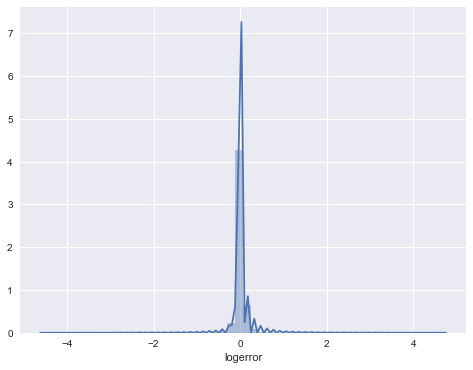

In [4]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
sns.distplot(train_data['logerror'], ax=ax)
fig.show()

In [5]:
# report train_data set mean, and cross validate mean model in train_data
print('mean logerror in train_data: %.6f' % np.mean(train_data['logerror']))
print('cv MAE in train_data: %.6f' % z.cv_mean_model(train_data['logerror']))

mean logerror in train_data: 0.011457
cv MAE in train_data: 0.068731


cv MAE in training data gives 0.068731, and on testing set, it is 0.0651282, This means training data has more extreme values than in testing data, yet, since these are actual transactions, we would not want to remove them for evaluation, and hopefully, we could some how gain prediction power on thoese extreme values.

Meanwhile, on testing set, predicting with mean is much better than predicting with 0 (0.0663010), meaning the positive bias in logerror is systemic.

## naive_lgb prediction.

Based on data exploration, I classified features into 4 categories, among them first class 1 and 2 are readily usable. So the benchmark model uses these features and tuned LightGBM, without

- outlier cleaning (neither x perspective or y perspective).
- feature engineering.
- handling seanality.
- handling outliers.

First take an overview of class1 and class2 features.

In [6]:
feature_info = pd.read_csv('data/feature_info.csv', index_col='new_name')
feature_info.drop('orig_name', axis=1, inplace=True)
keep_feature = feature_info.index[feature_info['class'].apply(lambda x: True if x in {1, 2} else False)].values
feature_select = feature_info.loc[keep_feature, :]
print(feature_select.shape)
display(feature_select.sort_values('class'))

(29, 4)


,type,class,prop_missing,train_missing
new_name,,,,
dollar_taxvalue_land,num,1,0.022689,0.000011
type_pool,cat,1,0.000000,0.000000
dollar_taxvalue_total,num,1,0.014254,0.000011
flag_tax_delinquency,cat,1,0.000000,0.000000
dollar_tax,num,1,0.010468,0.000067
dollar_taxvalue_structure,num,1,0.018418,0.004209
type_landuse,cat,1,0.003831,0.000000
area_lot,num,1,0.092489,0.112434
longitude,num,1,0.003831,0.000000


There are 29 of them in total, 8 of them are categorical.

Tuning LightGBM with CV, four parameters to concentrate on:
- min_data_in_leaf.
- learning_rate.
- num_leaf.
- lambda_12.

Random search is used, result is evaluated by correlation between MAE and each parameter value. If abs_corr is high meaning finer searching on one side in the range is meaningful, oherwise, we are indifferent in selecting a value in the range. Final used model is
- num_leaves = 40.
- learning_rate = 0.01.
- lambda_l2 = 0.02.
- min_data_in_leaf = 300.

Then number of boosting round is chosen by early_stopping_round together with validation. At last, final model for testing is trained on full data. All the following LightGBM tuning will be following this procedure.

In [7]:
reload(z)
test_x, train_x, train_y = z.load_data_naive_lgb(train_data, test_data)
lgb_train = lgb.Dataset(train_x, train_y)
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression_l1',
    'metric': {'l1'},
    'num_leaves': 40,
    'min_data_in_leaf': 300,
    'learning_rate': 0.01,
    'lambda_l2': 0.02,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.7,
    'bagging_freq': 5,
    'verbosity': 0
}
gbm = lgb.train(params, lgb_train, num_boost_round=1000)
eval_hist = lgb.cv(params, lgb_train, num_boost_round=1000)
print('cv MAE naive LightGBM: %.6f' % eval_hist['l1-mean'][-1])

cv MAE naive LightGBM: 0.067154


The cv MAE is smaller than 0.068731 of naive mean, and on testing set it is 0.0645428. Now we check the real feature importance determined by model. LightGBM provides two types of feature importance, one by number of splits for each feature, and one by total gain from using each feature in split.

In [8]:
reload(z)
df_split, df_gain = z.feature_importance(gbm)
df_display = pd.concat([df_split, df_gain], axis=1, join='outer')
display(df_display)

,class,feature,split,class,feature,gain
0,1,year_built,3996,1,year_built,1764.673888
1,1,latitude,3866,1,dollar_tax,1680.953865
2,1,area_lot,3668,1,area_living_type_12,1667.419066
3,1,longitude,3471,1,latitude,1619.861319
4,1,dollar_tax,3452,1,area_living_finished_calc,1539.949818
5,1,dollar_taxvalue_structure,3340,1,area_lot,1461.527406
6,1,area_living_type_12,3170,1,longitude,1358.485645
7,1,dollar_taxvalue_land,2960,1,dollar_taxvalue_structure,1317.876901
8,1,area_living_finished_calc,2507,1,dollar_taxvalue_land,1182.509141
9,1,dollar_taxvalue_total,2216,1,dollar_taxvalue_total,1166.348316


There is an obvious positive rank correlation between model feature importance and mannual marked feature quality. Surprisingly, code_fips got a very low usage.

## selected_feature prediction

Naive version uses all usable features, let's see if higher quality and smaller set of features can improve model performance, or LightGBM is smart enough to do feature selection internally and can make use of anything if existing.

Original plan is to use all class 1 features, but according to feature importance results, there some adjustments:
- remove following class 1 features, due to low rank:
    - code_fips.
    - num_fullbath.
    - flag_spa_zillow
    - flag_tax_delinquency
- keep following class 2 features:
    - area_garage, I put it as class 2 because of relatively high missing rate. If the pattern is so rich, not only I would want to use it now, but I will try to have a good missing imputation for it.
    - rank_building_quality, it was put as class 2 becuase no obvious pattern at high density area. From results, it seems that low density group (6, 8) shaded the scale.
    - area_pool, it was also dropped due to weak pattern. Now it tells that the pattern is not drastic but good enough.
    - num_bathroom_assessor, could also be miss-classified by scale shading.
    - num_unit, it is not very strong, but we kept type_pool and type_heating_system.

In [9]:
reload(z)
test_x, train_x, train_y = z.load_data_naive_lgb_feature_down(train_data, test_data)

In [10]:
reload(z)
lgb_train = lgb.Dataset(train_x, train_y)
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression_l1',
    'metric': {'l1'},
    'num_leaves': 40,
    'min_data_in_leaf': 300,
    'learning_rate': 0.01,
    'lambda_l2': 0.02,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.7,
    'bagging_freq': 5,
    'verbosity': 0
}
eval_hist = lgb.cv(params, lgb_train, num_boost_round=1000)
print('cv MAE naive LightGBM: %.6f' % eval_hist['l1-mean'][-1])

cv MAE naive LightGBM: 0.067191


Compared to naive version without feature downsize, the performance gets downgraded, meaning low quality features does not confuse LightGBM. 

## expanded_feature prediction

Now it worth looking if including class 4 features would improve the results.

In [11]:
reload(z)
test_x, train_x, train_y = z.load_data_naive_lgb_feature_up(train_data, test_data)
lgb_train = lgb.Dataset(train_x, train_y)
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression_l1',
    'metric': {'l1'},
    'num_leaves': 40,
    'min_data_in_leaf': 300,
    'learning_rate': 0.01,
    'lambda_l2': 0.02,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.7,
    'bagging_freq': 5,
    'verbosity': 0
}
eval_hist = lgb.cv(params, lgb_train, num_boost_round=1500)
print('cv MAE naive LightGBM: %.6f' % eval_hist['l1-mean'][-1])

cv MAE naive LightGBM: 0.067143


lgb params are not further tuned, but num_boost_round is increased due to more noise. cv MAE gets decreased a little bit. So get curious in what it might do to testing data. Testing MAE gets improved from 0.0645428 to 0.0644639. 

In [12]:
gbm = z.train_lgb(train_x, train_y, 1500)
df_split, df_gain = z.feature_importance(gbm)
df_display = pd.concat([df_split, df_gain], axis=1, join='outer')
display(df_display)

,class,feature,split,class,feature,gain
0,1,year_built,5694,1,year_built,2108.283189
1,1,latitude,5539,1,latitude,2049.224820
2,1,area_lot,5539,1,area_lot,1926.511265
3,1,dollar_taxvalue_structure,5195,1,dollar_tax,1914.989072
4,1,longitude,5080,1,area_living_type_12,1909.168882
5,1,dollar_tax,4699,1,area_living_finished_calc,1846.284699
6,1,area_living_type_12,4462,1,longitude,1768.611371
7,1,dollar_taxvalue_land,4439,1,dollar_taxvalue_structure,1737.730846
8,1,area_living_finished_calc,3645,1,dollar_taxvalue_land,1545.368544
9,1,dollar_taxvalue_total,3435,1,dollar_taxvalue_total,1437.979522


Take a further look at feature importance, indeed most type 4 features are useless. Yet, the 5 that ranks high:
- area_living_type_15
- area_firstfloor_zillow
- area_firstfloor_assessor
- area_yard_patio
- year_tax_due

They are all put into class-4 due to high missing rate (+95%), thus patterns are not viewed at all. Further more, as put in data_explore section type_pool should have already included flag_pool and type_pool_2 information. Let's finalize our naive_lgb version with class12 plus these 5 features. 

## naive_lgb_final model

In [13]:
reload(z)
test_x, train_x, train_y = z.load_data_naive_lgb_final(train_data, test_data)
lgb_train = lgb.Dataset(train_x, train_y)
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression_l1',
    'metric': {'l1'},
    'num_leaves': 40,
    'min_data_in_leaf': 300,
    'learning_rate': 0.01,
    'lambda_l2': 0.02,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.7,
    'bagging_freq': 5,
    'verbosity': 0
}
eval_hist = lgb.cv(params, lgb_train, num_boost_round=1500)
print('cv MAE naive LightGBM: %.6f' % eval_hist['l1-mean'][-1])

cv MAE naive LightGBM: 0.067142


Good to see cv MAE is not much compromised. Let's keep this as final naive_lgb model. On testing data, result is a bit worse off. from 0.0644639 to 0.0644925. It should be fine. And with less number of used features, model training and predicting process will be more efficient. 

## Feature Engineering

In this section, I will test adding or replacing one feature at a time on top of naive lgb benchmark. Engineered feature is expected to be strong, so:
- if it is a completely new feature, I will take a look at its average importance rank in both split and gain. A usable new feature should not be of last, say 10%. 
- if it is a feature to replace an existing feature. I will include both features in the model, and see if the new one performs better than the old one.

In [114]:
reload(z)
# fix original data set and parameters for feature engineering
test_x, train_x, train_y = z.load_data_naive_lgb_final(train_data, test_data)
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression_l1',
    'metric': {'l1'},
    'num_leaves': 40,
    'min_data_in_leaf': 300,
    'learning_rate': 0.01,
    'lambda_l2': 0.02,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.7,
    'bagging_freq': 5,
    'verbosity': 0
}

### Cleaning existing features

#### num_fullbath

group into {0, 1, 2, 3, 4, 5, >=6}, use as categorical.

In [97]:
reload(z)
def create_num_full_bath_new(data, raw_data):
    orig_name = nmap_new_to_orig['num_fullbath']
    data_out = data.copy()
    data_out['num_fullbath_new'] = raw_data[orig_name]
    data_out.loc[data_out.index[raw_data[orig_name] >= 6], 'num_fullbath_new'] = 6
    z.cat_num_to_str_inner(data_out, 'num_fullbath_new')
    z.convert_cat_col_single(data_out, 'num_fullbath_new')
    data_out.drop(orig_name, axis=1, inplace=True)
    return data_out
    
train_x_local = create_num_full_bath_new(train_x, train_data)
gbm = z.train_lgb(train_x_local, train_y)
z.feature_importance_rank(gbm, 'num_fullbath_new', 'num_fullbath')

n_features total: 34
num_fullbath_new: rank split = 17, rank gain = 19, avg_rank = 18.0
num_fullbath: rank split = 21, rank gain = 21, avg_rank = 21.0
cv MAE naive LightGBM: 0.067142


Improve is quite limited, but we do observe improvement.

Try impute the nan num_fullbath from num_bathroom, from data exploration, this imputes about 1.3% of fullbath data.

In [133]:
reload(z)
def nan_impute_fullbathcnt(data, raw_data):
    orig_name_fullbath = nmap_new_to_orig['num_fullbath']
    orig_name_bath = nmap_new_to_orig['num_bathroom_assessor']
    data_out = data.copy()
    null_idx = raw_data.index[data[orig_name_fullbath].isnull()]
    fill_val = raw_data[orig_name_bath][null_idx].copy()
    fill_val_raw = fill_val.copy()
    fill_val_raw_floor = fill_val_raw.apply(math.floor)
    int_idx = np.abs(fill_val_raw.values - fill_val_raw_floor.values) < 1e-12
    fill_val[int_idx] = np.maximum(fill_val_raw[int_idx] - 1, 0)
    fill_val[~int_idx] = fill_val_raw_floor[~int_idx]
    data_out['num_fullbath_impute'] = raw_data[orig_name_fullbath]
    data_out.loc[null_idx, 'num_fullbath_impute']= fill_val
    z.cat_num_to_str_inner(data_out, 'num_fullbath_impute')
    z.convert_cat_col_single(data_out, 'num_fullbath_impute')
    data_out.drop(orig_name_fullbath, axis=1, inplace=True)
    return data_out

train_x_local = nan_impute_fullbathcnt(train_x, train_data)
gbm = z.train_lgb(train_x_local, train_y)
z.feature_importance_rank(gbm, 'num_fullbath_impute', 'num_fullbath')

n_features total: 34
num_fullbath_impute: rank split = 18, rank gain = 19, avg_rank = 18.5
num_fullbath: rank split = 21, rank gain = 21, avg_rank = 21.0


In [147]:
# combine above 2 operations
reload(z)
def nan_impute_fullbathcnt(data, raw_data):
    orig_name_fullbath = nmap_new_to_orig['num_fullbath']
    orig_name_bath = nmap_new_to_orig['num_bathroom_assessor']
    data_out = data.copy()
    
    null_idx = raw_data.index[data[orig_name_fullbath].isnull()]
    fill_val = raw_data[orig_name_bath][null_idx].copy()
    fill_val_floor = fill_val.apply(math.floor)
    int_idx = np.abs(fill_val.values - fill_val_floor.values) < 1e-12
    fill_val[int_idx] = np.maximum(fill_val[int_idx] - 1, 0)
    fill_val[~int_idx] = fill_val_floor[~int_idx]
    data_out['num_fullbath_impute'] = raw_data[orig_name_fullbath]
    data_out.loc[null_idx, 'num_fullbath_impute']= fill_val
    
    data_out['num_fullbath_clean'] = data_out['num_fullbath_impute']
    data_out.loc[data_out.index[data_out['num_fullbath_clean'] >= 6], 'num_fullbath_clean'] = 6
    z.cat_num_to_str_inner(data_out, 'num_fullbath_clean')
    z.convert_cat_col_single(data_out, 'num_fullbath_clean')
    data_out.drop(orig_name_fullbath, axis=1, inplace=True)
    data_out.drop('num_fullbath_impute', axis=1, inplace=True)
    
    return data_out

train_x_local = nan_impute_fullbathcnt(train_x, train_data)
gbm = z.train_lgb(train_x_local, train_y)
z.feature_importance_rank(gbm, 'num_fullbath_clean', 'num_fullbath')
    

n_features total: 34
num_fullbath_clean: rank split = 19, rank gain = 19, avg_rank = 19.0
num_fullbath: rank split = 21, rank gain = 21, avg_rank = 21.0


it is actually worse than using grouping alone, but let's keep it this way as logically it makes more sense.

#### num_fireplace

group into {1, 2, >=3}, leave nan as it is, make it categorical

In [26]:
reload(z)
def create_num_full_bath_new(data, raw_data):
    orig_name = nmap_new_to_orig['num_fireplace']
    data_out = data.copy()
    data_out['num_fireplace_new'] = raw_data[orig_name]
    data_out.loc[data_out.index[raw_data[orig_name] >= 3], 'num_fireplace_new'] = 3
    z.cat_num_to_str_inner(data_out, 'num_fireplace_new')
    z.convert_cat_col_single(data_out, 'num_fireplace_new')
    data_out.drop(orig_name, axis=1, inplace=True)
    return data_out
    
train_x_local = create_num_full_bath_new(train_x, train_data)
gbm = z.train_lgb(train_x_local, train_y)
z.feature_importance_rank(gbm, 'num_fireplace_new', 'num_fireplace')

n_features total: 35
num_fireplace_new: rank split = 35, rank gain = 35, avg_rank = 35.0
num_fireplace: rank split = 32, rank gain = 32, avg_rank = 32.0


no improvement, leave num_fireplace as it is.

#### area_garage

it is a high rank variable and missing rate is high: ~76%. Let's see if naive imputation could work, fill by mean. Note there are also cases when we have zero area but non_zero count. also impute for it.

In [139]:
reload(z)
def create_area_garage_impute(data, raw_data):
    orig_name = nmap_new_to_orig['area_garage']
    data_out = data.copy()
    data_out['area_garage_impute'] = raw_data[orig_name]
    # first set 0 area and non-zero count samples to nan
    target_idx = np.logical_and(data_out['area_garage_impute'] == 0, raw_data['garagecarcnt'] > 0)
    data_out.loc[target_idx, 'area_garage_impute'] = np.nan
    # then impute resst by pure mean
    data_out['area_garage_impute'].fillna(data_out['area_garage_impute'].mean(), inplace=True)
    return data_out
    
train_x_local = create_area_garage_impute(train_x, train_data)
gbm = z.train_lgb(train_x_local, train_y)
z.feature_importance_rank(gbm, 'area_garage_impute', 'area_garage')

n_features total: 35
area_garage_impute: rank split = 20, rank gain = 22, avg_rank = 21.0
area_garage: rank split = 11, rank gain = 11, avg_rank = 11.0


Let's not mess up this feature..

### combination of existing features

#### num_bathroom

we have num_bathroom_zillow and num_bathroom_assessor, let's see if the difference gives more information, try both abs diff and non-abs diff.

In [69]:
reload(z)
orig_name_zillow = nmap_new_to_orig['num_bathroom_zillow']
orig_name_assessor = nmap_new_to_orig['num_bathroom_assessor']
diff_col = train_data[orig_name_zillow] - train_data[orig_name_assessor]
print('max_diff: %.2f' % np.nanmax(diff_col.values))
print('min_diff: %.2f' % np.nanmin(diff_col.values))

# create feature on missing disagreed samples
def create_num_bathroom_diff(data, raw_data):
    data_out = data.copy()
    data_out['num_bathroom_diff'] = np.logical_xor(raw_data[orig_name_zillow].isnull(), raw_data[orig_name_assessor].isnull())
    z.convert_cat_col_single(data_out, 'num_bathroom_diff')
    return data_out
    
train_x_local = create_num_bathroom_diff(train_x, train_data)
gbm = z.train_lgb(train_x_local, train_y)
z.feature_importance_rank(gbm, 'num_bathroom_diff')

max_diff: 0.00
min_diff: 0.00
n_features total: 35
num_bathroom_diff: rank split = 35, rank gain = 35, avg_rank = 35.0


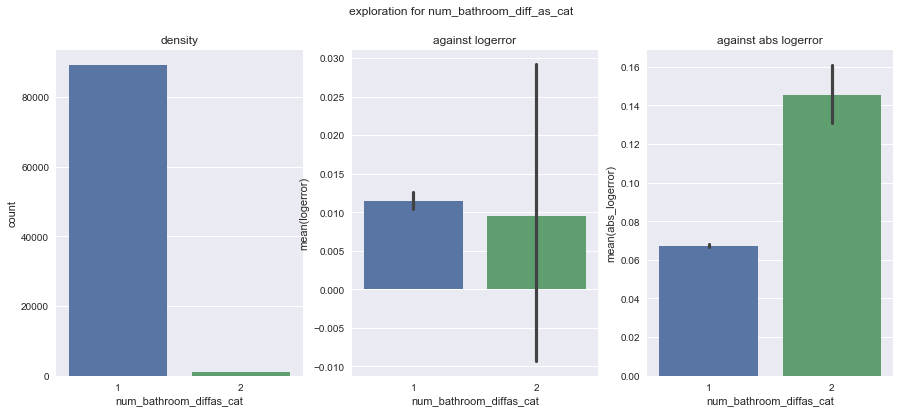

In [71]:
visual_analysis_num_as_cat(train_x_local['num_bathroom_diff'], train_data['logerror'], train_data['abs_logerror'], 'num_bathroom_diff', 'num_bathroom_diff')

It contains good information for abs_error but not for original error. And size of diff samples is too small. 

#### area_living

diff between area_living_finished_calc and area_living_type_12.

In [66]:
reload(z)
orig_name_finished = nmap_new_to_orig['area_living_finished_calc']
orig_name_type12 = nmap_new_to_orig['area_living_type_12']
diff_col = train_data[orig_name_finished] - train_data[orig_name_type12]
print('max_diff: %.2f' % np.nanmax(diff_col.values))
print('min_diff: %.2f' % np.nanmin(diff_col.values))
# no difference on value recorded samples

# create feature on missing disagreed samples
def create_living_area_diff(data, raw_data):
    data_out = data.copy()
    data_out['area_living_diff'] = np.logical_xor(raw_data[orig_name_finished].isnull(), raw_data[orig_name_type12].isnull())
    z.convert_cat_col_single(data_out, 'area_living_diff')
    return data_out
    
train_x_local = create_living_area_diff(train_x, train_data)
gbm = z.train_lgb(train_x_local, train_y)
z.feature_importance_rank(gbm, 'area_living_diff')

max_diff: 0.00
min_diff: 0.00
n_features total: 35
area_living_diff: rank split = 34, rank gain = 34, avg_rank = 34.0


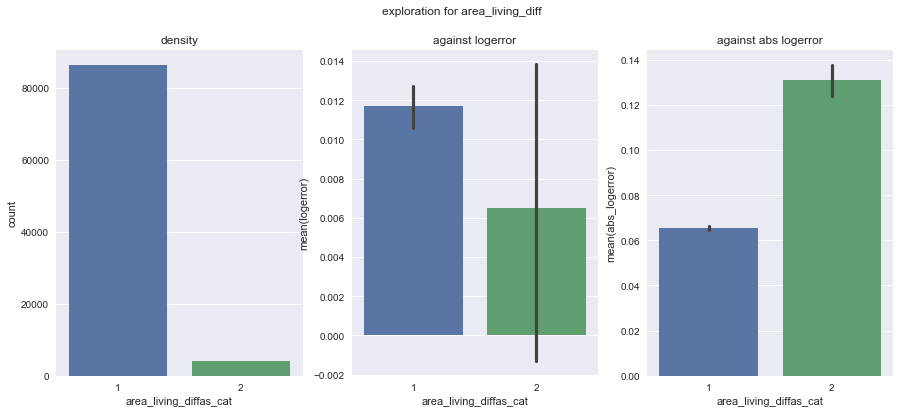

In [67]:
visual_analysis_num_as_cat(train_x_local['area_living_diff'], train_data['logerror'], train_data['abs_logerror'], 'area_living_diff', 'area_living_diff')

It contains good information for abs_error but not for original error.

#### area_firstfloor

area_firstfloor_zillow and area_firstfloor_assessor, they are uplifted class 4 features.

In [76]:
reload(z)
orig_name_zillow = nmap_new_to_orig['area_firstfloor_zillow']
orig_name_assessor = nmap_new_to_orig['area_firstfloor_assessor']
diff_col = train_data[orig_name_finished] - train_data[orig_name_type12]
print('max_diff: %.2f' % np.nanmax(diff_col.values))
print('min_diff: %.2f' % np.nanmin(diff_col.values))
# no difference on value recorded samples

print('n diff on missing: %d' % np.sum(np.logical_xor(train_data[orig_name_zillow].isnull(), train_data[orig_name_assessor].isnull())))

max_diff: 0.00
min_diff: 0.00
n diff on missing: 0


Interesting, they are exactly the same. From above analysis, zillow and assessor disgreeded values gives little information in prediction error value, but may help with error size.

#### tax value variables

We have dollar_taxvalue_structure, dollar_taxvalue_total, dollar_taxvalue_land, difference bewteen any two may contain information.

In [86]:
col = train_data[nmap_new_to_orig['dollar_taxvalue_structure']] + \
      train_data[nmap_new_to_orig['dollar_taxvalue_land']] - \
      train_data[nmap_new_to_orig['dollar_taxvalue_total']]
print('max_diff: %.2f' % np.nanmax(col.values))
print('min_diff: %.2f' % np.nanmin(col.values))

max_diff: 0.00
min_diff: 0.00


First observe, we have relationship as total = land + structure.
So it only makes sense to test:
- structure - land
- abs(structure - land)

In [96]:
reload(z)
orig_name_structrue = nmap_new_to_orig['dollar_taxvalue_structure']
orig_name_land = nmap_new_to_orig['dollar_taxvalue_land']

def create_taxvalue_diff(data, raw_data):
    data_out = data.copy()
    data_out['dollar_taxvalue_structure_land_diff'] = raw_data[orig_name_structrue] - raw_data[orig_name_land]
    data_out['dollar_taxvalue_structure_land_absdiff'] = np.abs(raw_data[orig_name_structrue] - raw_data[orig_name_land])
    return data_out

train_x_local = create_taxvalue_diff(train_x, train_data)
gbm = z.train_lgb(train_x_local, train_y)
z.feature_importance_rank(gbm, 'dollar_taxvalue_structure_land_diff')
z.feature_importance_rank(gbm, 'dollar_taxvalue_structure_land_absdiff')
z.cv_lgb_final(train_x_local, train_y)
print('cv MAE: %.6f' % z.cv_lgb_final(train_x_local, train_y))

n_features total: 36
dollar_taxvalue_structure_land_diff: rank split = 12, rank gain = 12, avg_rank = 12.0
n_features total: 36
dollar_taxvalue_structure_land_absdiff: rank split = 9, rank gain = 11, avg_rank = 10.0


0.067156491217731623

Ranking looks good, but cv actually gets worse, which means, the rich info in the new variable tends to overfit, let's hold it for the moment.

Try ratio between variables, proves to be a good contributing feature.

In [145]:
reload(z)
orig_name_structrue = nmap_new_to_orig['dollar_taxvalue_structure']
orig_name_land = nmap_new_to_orig['dollar_taxvalue_land']
orig_name_total = nmap_new_to_orig['dollar_taxvalue_total']

def create_taxvalue_diff(data, raw_data):
    data_out = data.copy()
    data_out['dollar_taxvalue_structure_total_ratio'] = raw_data[orig_name_structrue] / raw_data[orig_name_total]
    data_out['dollar_taxvalue_structure_land_ratio'] = raw_data[orig_name_structrue] / raw_data[orig_name_land]
    data_out['dollar_taxvalue_total_structure_ratio'] = raw_data[orig_name_total] / raw_data[orig_name_structrue]
    data_out['dollar_taxvalue_total_land_ratio'] = raw_data[orig_name_total] / raw_data[orig_name_land]
    data_out['dollar_taxvalue_land_structure_ratio'] = raw_data[orig_name_land] / raw_data[orig_name_structrue] 
    return data_out

train_x_local = create_taxvalue_diff(train_x, train_data)
gbm = z.train_lgb(train_x_local, train_y)
z.feature_importance_rank(gbm, 'dollar_taxvalue_structure_total_ratio')
z.feature_importance_rank(gbm, 'dollar_taxvalue_structure_land_ratio')
z.feature_importance_rank(gbm, 'dollar_taxvalue_total_structure_ratio')
z.feature_importance_rank(gbm, 'dollar_taxvalue_land_structure_ratio')
z.feature_importance_rank(gbm, 'dollar_taxvalue_total_land_ratio')
z.cv_lgb_final(train_x_local, train_y)
print('cv MAE: %.6f' % z.cv_lgb_final(train_x_local, train_y))

n_features total: 39
dollar_taxvalue_structure_total_ratio: rank split = 11, rank gain = 11, avg_rank = 11.0
n_features total: 39
dollar_taxvalue_structure_land_ratio: rank split = 22, rank gain = 22, avg_rank = 22.0
n_features total: 39
dollar_taxvalue_total_structure_ratio: rank split = 12, rank gain = 12, avg_rank = 12.0
n_features total: 39
dollar_taxvalue_land_structure_ratio: rank split = 24, rank gain = 24, avg_rank = 24.0
cv MAE: 0.067134


### make use of class 3 variables

They are directly usable by LightGBM, but number of classes being too high makes it inefficient to run. Let's first walk them one by one to see how each one of them helps.

#### code_county_landuse

number of categories: 78.

In [116]:
train_x_local = train_x.copy()
train_x_local['code_county_landuse_orig'] = train_data['propertycountylandusecode']
z.convert_cat_col_single(train_x_local, 'code_county_landuse_orig')
gbm = z.train_lgb(train_x_local, train_y)
z.feature_importance_rank(gbm, 'code_county_landuse_orig')

n_features total: 35
code_county_landuse_orig: rank split = 13, rank gain = 14, avg_rank = 13.5


#### str_zoning_desc
number of categories: 1997

In [117]:
train_x_local = train_x.copy()
train_x_local['str_zoning_desc_orig'] = train_data['propertyzoningdesc']
z.convert_cat_col_single(train_x_local, 'str_zoning_desc_orig')
gbm = z.train_lgb(train_x_local, train_y)
z.feature_importance_rank(gbm, 'str_zoning_desc_orig')

n_features total: 35
str_zoning_desc_orig: rank split = 13, rank gain = 14, avg_rank = 13.5


#### code_city
number of categories: 178

In [121]:
train_x_local = train_x.copy()
train_x_local['code_city_orig'] = train_data['regionidcity']
z.convert_cat_col_single(train_x_local, 'code_city_orig')
gbm = z.train_lgb(train_x_local, train_y)
z.feature_importance_rank(gbm, 'code_city_orig')

n_features total: 35
code_city_orig: rank split = 11, rank gain = 11, avg_rank = 11.0


#### code_neighborhood
number of categories: 495

In [122]:
train_x_local = train_x.copy()
train_x_local['code_neighborhood_orig'] = train_data['regionidneighborhood']
z.convert_cat_col_single(train_x_local, 'code_neighborhood_orig')
gbm = z.train_lgb(train_x_local, train_y)
z.feature_importance_rank(gbm, 'code_neighborhood_orig')

n_features total: 35
code_neighborhood_orig: rank split = 13, rank gain = 13, avg_rank = 13.0


#### code_zip

number of categories: 389

In [123]:
train_x_local = train_x.copy()
train_x_local['code_zip_orig'] = train_data['regionidzip']
z.convert_cat_col_single(train_x_local, 'code_zip_orig')
gbm = z.train_lgb(train_x_local, train_y)
z.feature_importance_rank(gbm, 'code_zip_orig')

n_features total: 35
code_zip_orig: rank split = 14, rank gain = 19, avg_rank = 16.5


#### raw_census
number of categories: 3002

In [124]:
train_x_local = train_x.copy()
train_x_local['raw_census_orig'] = train_data['raw_census']
z.convert_cat_col_single(train_x_local, 'raw_census_orig')
gbm = z.train_lgb(train_x_local, train_y)
z.feature_importance_rank(gbm, 'raw_census_orig')

n_features total: 35
raw_census_orig: rank split = 35, rank gain = 35, avg_rank = 35.0


#### raw_block
number of categories: 686

In [125]:
train_x_local = train_x.copy()
train_x_local['raw_block_orig'] = train_data['raw_block']
z.convert_cat_col_single(train_x_local, 'raw_block_orig')
gbm = z.train_lgb(train_x_local, train_y)
z.feature_importance_rank(gbm, 'raw_block_orig')

n_features total: 35
raw_block_orig: rank split = 11, rank gain = 14, avg_rank = 12.5


#### census
number of categories: 2997

In [126]:
train_x_local = train_x.copy()
train_x_local['census_orig'] = train_data['census']
z.convert_cat_col_single(train_x_local, 'census_orig')
gbm = z.train_lgb(train_x_local, train_y)
z.feature_importance_rank(gbm, 'census_orig')

n_features total: 35
census_orig: rank split = 34, rank gain = 32, avg_rank = 33.0


#### block

number of categories: 695

In [127]:
train_x_local = train_x.copy()
train_x_local['block_orig'] = train_data['block']
z.convert_cat_col_single(train_x_local, 'block_orig')
gbm = z.train_lgb(train_x_local, train_y)
z.feature_importance_rank(gbm, 'block_orig')

n_features total: 35
block_orig: rank split = 11, rank gain = 14, avg_rank = 12.5


Except for the census and census_raw, all are well qualified to be used for prediction.

### Summarize for feature engineering

- num_fullbath: grouping > 6 values and fill with num_bathroom when applicable (replace original one)
- dollar_taxvalue variables:
    - structure - land
    - abs(structure - land)
    - structure / total
    - structure / land
    - total / structure
    - land / structure
    - total / land
- class 3 variables:
    - code_county_landuse
    - str_zoning_desc
    - code_city
    - code_neighborhood
    - code_zip
    - raw_block
    - block

## Effect of removing outliers

To verify the effect of outlier removal, we still just use naive LGB as benchmark model. NOTE, to perform cv on outlier removal effect, cannot first remove all outliers before entering cv, the correct way to do it should be, 
- enter cv with full data.
- select train_set and validation_set.
- remove outlier from train_set and train(be careful to create a copy for outlier removal, not on view.)
- compute MAE on test set.

### Outlier on x side. 
If to remove outliers, we only remove those rows for training. Testing data is left untouched.
- For categorical variables, we observe there are groups that contain very little samples, remove those groups.
- For numerical variables, might remove one-sided 1% or two-sided 1% samples. Whether to remove or remove by what type should be on case-by-case.

Will also test the effect of setting those values to nan. For nan setting it is a bit subtle. As we need to perform the same treatment on testing set. in this case, I will determine the 1% threshold from testing dateset and apply the value for both testing and training data, instead of picking 1% separately again for training. 

### Outlier on y side.
This case is much simpler, just train with extreme y values removed.